# ArcticDEM

In [ ]:
import os

import geopandas as gpd
import numpy as np
import pdemtools as pdt
import xarray as xr
from rasterio.enums import Resampling

VARS = [
    "dem_id",
    "pairname",
    "stripdemid",
    "acqdate1",
    "acqdate2",
    "gsd",
    "epsg",
    "setsm_ver",
    "s2s_ver",
    "creationdate",
    "geocell",
    "is_lsf",
    "is_xtrack",
    "valid_area_matchtag_density",
    "valid_area_percent",
    "cloud_area_percent",
    "fileurl",
    "s3url",
]

ATTRS = {
    "x": {
        "description": "x coordinate of projection",
        "units": "metres",
    },
    "y": {
        "description": "y coordinate of projection",
        "units": "metres",
    },
    "glacier_code": {
        "description": "Initials of glacier name",
    },
    "cd": {
        "description": "Distance of point along centre flowline of glacier (cd=centreline distance)",
        "units": "metres from minimum observed terminus position (positive=upstream)",
    },
    "h": {
        "description": "Elevation relative to the WGS84 ellipsoid",
        "units": "metres",
    },
    "mosaic": {
        "description": "Elevation relative to the WGS84 ellipsoid from ArcticDEM mosaic",
        "units": "metres",
    },
    "coreg_rmse": {
        "description": "Final RMSE of the coregistration transformation in the vertical (z) dimension from the residuals",
        "units": "metres",
    },
    "coreg_trans_z": {
        "description": "z transformation paramater",
        "units": "metres",
    },
    "coreg_trans_x": {
        "description": "x transformation paramater",
        "units": "metres",
    },
    "coreg_trans_y": {
        "description": "y transformation paramater",
        "units": "metres",
    },
    "coreg_trans_z_err": {
        "description": "1-sigma error of the z transformation paramater",
        "units": "metres",
    },
    "coreg_trans_x_err": {
        "description": "1-sigma error of the x transformation paramater",
        "units": "metres",
    },
    "coreg_trans_y_err": {
        "description": "1-sigma error of the y transformation paramater",
        "units": "metres",
    },
    "acqdate1": {
        "description": "Acquisition date for Image 1 of the stereopair",
    },
    "acqdate2": {
        "description": "Acquisition date for Image 2 of the stereopair.",
    },
    "cloud_area_percent": {
        "description": "Percent of all data pixels in the DEM identified as potentially cloud cover in the bitmask",
        "units": "percent",
    },
    "creationdate": {
        "description": "Date of scenes2strips processing for the strip DEM",
    },
    "dem_id": {
        "description": "Identifier for the produced DEM strip segment",
        "format": "ALGORTHM_VERSION_SENSOR_DATE_IMAGE1_IMAGE2_SEGMENT_RESOLUTION_FILETYPE",
    },
    "epsg": {
        "description": "EPSG code identifier for the DEM spatial reference system",
    },
    "fileurl": {
        "description": "URL to HTTP download of tarball containing all files for the DEM strip segment",
    },
    "geocell": {
        "description": "1 degree latitude by 1 degree longitude cell that contains the strip DEM centroid",
    },
    "gsd": {"description": "Ground sample distance of the DEM", "units": "metres"},
    "is_lsf": {
        "description": "Whether the strip DEM was built from SETSM results run through SETSM’s Local Surface Fitting module",
        "units": "binary (1=yes/0=no)",
    },
    "is_xtrack": {
        "description": "Whether the stereopair is cross-track imagery (otherwise it is in-track imagery)",
        "units": "binary (1=yes/0=no)",
    },
    "pairname": {
        "description": "Identifier for the stereopair",
    },
    "s2s_ver": {
        "description": "scenes2strips version used to process the strip DEM",
    },
    "s3url": {
        "description": "URL to AWS S3 STAC index record for the DEM strip segment",
    },
    "setsm_ver": {
        "description": "SETSM version used to build the stereopair scene DEMs",
    },
    "stripdemid": {
        "description": "Identifier for the stereopair built with indicated SETSM version and resolution",
    },
    "valid_area_matchtag_density": {
        "description": "Ratio of data pixels in the DEM marked as match points from SETSM, considering only valid data pixels",
    },
    "valid_area_percent": {
        "description": "Percent of all data pixels in the DEM considered valid data",
        "units": "percent",
    },
    "author": {
        "author": "Porter et al.",
    },
    "institution": {
        "institution": "Polar Geospatial Center (PGC), College of Science and Engineering, University of Minnesota",
    },
    "region": {
        "region": "RGI05A",
    },
    "projection": {
        "projection": "3413",
    },
    "title": {
        "title": "ArcticDEM strip DEMs",
    },
    "version": {
        "version": "v4.1",
    },
}

# ArcticDEM filter parameters
DATASET = "arcticdem"
VERSION = "v4.1"
RESOLUTION = 32
DATE_RANGE = "20000101/20240101"
BASELINE_MAX_HOURS = 24
MIN_VALID_AREA_FRAC = 0.50

# Output directory
BASE_DIR = "../data/elevation/arcticdem"
WRITE_DEM_AS_TIF = False

# Paths for BedMachine-v5 and ArcticDEM strip index
bedmachine_fpath = "../data/misc/bedmachine/BedMachineGreenland-v5.nc"
strip_index_fpath = f"{BASE_DIR}/ArcticDEM_Strip_Index_s2s041.parquet"

# Read and filter centreline points
points = gpd.read_file("../data/misc/centreline_points.geojson")
points = points.sort_values(by=["glacier_code", "cd"])
points = points[points.cd.between(-15000, 40000)].reset_index()

# Group by and iterate over each glacier
for glacier, points_glacier in points.groupby(by="glacier_code"):
    # Extract bounding coords of points for ArcticDEM search/clip
    bounds = tuple(points_glacier.total_bounds)

    # Get reference DEM (ArcticDEM mosaic)
    reference_dem = pdt.load.mosaic(
        dataset=DATASET,
        resolution=RESOLUTION,
        bounds=bounds,
        version=VERSION,
    ).squeeze()

    # Load BedMachine-v5 bedrock mask and geoid
    bedrock_mask = pdt.data.bedrock_mask_from_bedmachine(bedmachine_fpath, reference_dem)
    geoid = pdt.data.geoid_from_bedmachine(bedmachine_fpath, reference_dem)

    # Adjust reference DEM to geoid
    reference_dem = reference_dem.pdt.geoid_correct(geoid)

    # Search for DEM strips
    gdf = pdt.search(
        index_fpath=strip_index_fpath,
        bounds=bounds,
        dates=DATE_RANGE,
        baseline_max_hours=BASELINE_MAX_HOURS,
        min_valid_area_frac=MIN_VALID_AREA_FRAC,
        # months=[6, 7, 8, 9],
        # years=[2019],
    )
    gdf = gdf.sort_values("acqdate1")

    # To store pre-stacked strip DEMs of current glacier
    dem_stack = []

    # Iterate over all identified strip DEMs
    for i, row in gdf.reset_index().iterrows():
        # Load strip DEM, resample, correct to geoid, and coregister
        dem = pdt.load.from_search(row, bounds=bounds, bitmask=True)
        dem = dem.rio.reproject_match(
            reference_dem, resampling=Resampling.bilinear, nodata=np.nan
        )
        dem = dem.pdt.geoid_correct(geoid)
        dem, coreg_trans, coreg_trans_err, coreg_rmse = dem.pdt.coregister(
            reference_dem, bedrock_mask, max_horiz_offset=50, return_stats=True
        )

        # Name, reshape, and add date as dimension to current DEM
        dem = dem.to_dataset(name="h").transpose("x", "y")
        dem = dem.expand_dims(dim=["date"])
        dem = dem.assign_coords(date=("date", [row.acqdate1]))

        # Add variables for coregistration results and metadata
        dem["coreg_rmse"] = ("date", [coreg_rmse])
        dem["coreg_trans_z"] = ("date", [coreg_trans[0]])
        dem["coreg_trans_x"] = ("date", [coreg_trans[1]])
        dem["coreg_trans_y"] = ("date", [coreg_trans[2]])
        dem["coreg_trans_z_err"] = ("date", [coreg_trans_err[0]])
        dem["coreg_trans_x_err"] = ("date", [coreg_trans_err[1]])
        dem["coreg_trans_y_err"] = ("date", [coreg_trans_err[2]])
        for var in VARS:
            dem[var] = ("date", [row[var]])

        dem_stack.append(dem)

        # Convert to and save DEM as GeoTIFF raster
        if WRITE_DEM_AS_TIF:
            # Construct unique filename for current DEM
            date = row.acqdate1.date().strftime("%Y%m%d")
            id = row.dem_id
            dem_fpath = (
                f"{BASE_DIR}/{glacier.lower()}_{date}_{id}_resamp_{RESOLUTION}m_coreg.tif"
            )
            # Squeeze from 3D (x, y, date) to 2D (y, x) and save to disk
            dem = dem.squeeze()
            dem = dem.h.transpose("y", "x")
            dem.rio.to_raster(dem_fpath, compress="ZSTD", predictor=3, zlevel=1)

        # Clear DEM from memory
        del dem

    # Write stack of all DEMs (+ their metadata) for current glacier (+ mosaic) to disk
    dems_fpath = f"{BASE_DIR}/elevation_arcticdem_strips_{glacier.lower()}_geoid.nc"
    dems = xr.concat(dem_stack, dim="date")
    dems["mosaic"] = (("x", "y"), reference_dem.transpose("x", "y").data)

    for key, val in ATTRS.items():
        if key in list(dems.coords) + list(dems.keys()):
            dems[key].attrs = val
        if key in ["author", "institution", "region", "projection", "title", "version"]:
            dems.attrs[key] = val[key]

    dems.to_netcdf(dems_fpath)

In [ ]:
# Output directory
BASE_DIR = "../data/elevation/arcticdem"

# Read and filter centreline points
points = gpd.read_file("../data/misc/centreline_points.geojson")
points = points.sort_values(by=["glacier_code", "cd"])
points = points[points.cd.between(-15000, 40000)].reset_index()

# To store pre-concatenated sampled elevation results
arcticdem_results_ui = []
arcticdem_results_dj = []

# Group by and iterate over each glacier
for glacier, points_glacier in points.groupby(by="glacier_code"):
    dems = xr.open_dataset(f"{BASE_DIR}/elevation_arcticdem_strips_{glacier.lower()}_geoid.nc")

    # Iterate over each centreline point
    for j, point in points_glacier.reset_index().iterrows():
        # Define slices for x and y bounds of sampling box
        x = points_glacier.geometry.x.values
        y = points_glacier.geometry.y.values
        x_slice = slice(x[j] - 50, x[j] + 50)
        y_slice = slice(y[j] + 50, y[j] - 50)

        # Subset DEM by box
        subset = dems.sel(x=x_slice, y=y_slice)

        # Sample median elevation within box
        subset = subset.median(dim=["x", "y"])

        # Assign dimension (glacier_code, cd) of current point
        subset = subset.expand_dims(dim=["glacier_code", "cd"])
        subset = subset.assign_coords(
            glacier_code=("glacier_code", [point.glacier_code]),
            cd=("cd", [point.cd]),
        )
        if glacier == "DJ":
            arcticdem_results_dj.append(subset)
        if glacier == "UI":
            arcticdem_results_ui.append(subset)

dem_results_dj = xr.combine_by_coords(arcticdem_results_dj)
dem_results_ui = xr.combine_by_coords(arcticdem_results_ui)
dem_results = xr.combine_nested([dem_results_dj, dem_results_ui], concat_dim="date")

# Assign x and y coords for each point
points = points.set_index(["glacier_code", "cd"])
x_coords = points.geometry.x.unstack().values
y_coords = points.geometry.y.unstack().values
vel_results = dem_results.assign_coords(
    x=(("glacier_code", "cd"), x_coords),
    y=(("glacier_code", "cd"), y_coords),
)

# Write sampled results to disk
dem_results.to_netcdf(
    "../data/elevation/arcticdem/elevation_arcticdem_points_2011_2022_geoid.nc"
)

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from matplotlib.dates import DateFormatter, YearLocator
from matplotlib.offsetbox import AnchoredText
from matplotlib.gridspec import GridSpec

GLACIERS = ["DJ", "UI"]
SETTINGS = {
    "DJ": {
        "colour": [(0.122, 0.467, 0.706, 1.0), (0.122, 0.467, 0.706, 0.25)],
        "label": "Daugaard-Jensen",
    },
    "UI": {
        "colour": [(1.0, 0.498, 0.055, 1.0), (1.0, 0.498, 0.055, 0.25)],
        "label": "Uunartit Islands",
    },
}

# Global plot settings
plt.rcParams["figure.dpi"] = 1000
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 18
plt.rcParams["axes.labelsize"] = 18
plt.rcParams["xtick.labelsize"] = 18
plt.rcParams["ytick.labelsize"] = 18

# Create figure and axes
fig = plt.figure(figsize=(16, 6))
gs = GridSpec(nrows=1, ncols=2, width_ratios=[1, 2], height_ratios=[1])
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1:])
ax = [ax0, ax1]

dem_results = xr.open_dataset(
    "../data/elevation/arcticdem/elevation_arcticdem_points_2011_2022_geoid.nc"
).load()
dem_results = dem_results.sel(cd=1000)
dem_results_dj = dem_results.sel(glacier_code="DJ")
dem_results_ui = dem_results.sel(glacier_code="UI")
dj_dh = (
    dem_results_dj.h.squeeze().dropna("date") - dem_results_dj.h.squeeze().dropna("date")[0]
)
ui_dh = (
    dem_results_ui.h.squeeze().dropna("date") - dem_results_ui.h.squeeze().dropna("date")[0]
)

ax[1].plot(
    dj_dh.date.values,
    dj_dh,
    label=SETTINGS["DJ"]["label"],
    marker="o",
    linewidth=2.5,
    markersize=5,
    markeredgecolor=SETTINGS["DJ"]["colour"][0],
    markerfacecolor=SETTINGS["DJ"]["colour"][0],
    color=SETTINGS["DJ"]["colour"][1],
)
ax[1].plot(
    ui_dh.date.values,
    ui_dh,
    label=SETTINGS["UI"]["label"],
    marker="o",
    linewidth=2.5,
    markersize=5,
    markeredgecolor=SETTINGS["UI"]["colour"][0],
    markerfacecolor=SETTINGS["UI"]["colour"][0],
    color=SETTINGS["UI"]["colour"][1],
)

# Set y-axis range to fit data and adds label
ax[0].set_ylim(bottom=-140, top=20)
ax[1].set_ylim(bottom=-140, top=20)
ax[0].set_ylabel("Relative elevation [m]", labelpad=20)

# Set x-axis range to fit data
ax[0].set_xlim(pd.to_datetime("1985-01-01"), pd.to_datetime("2010-01-01"))
ax[1].set_xlim(pd.to_datetime("2010-01-01"), pd.to_datetime("2024-01-01"))

# Set x-axis tick frequency (major)
ax[0].xaxis.set_major_locator(YearLocator(base=5))
ax[0].xaxis.set_major_formatter(DateFormatter("%Y"))
ax[1].xaxis.set_major_formatter(DateFormatter("%Y"))

# Set x-axis tick frequency (minor)
ax[0].xaxis.set_minor_locator(YearLocator(1))
ax[1].xaxis.set_minor_locator(YearLocator(1))

# Rotate x-axis tick labels
ax[0].tick_params(axis="x", rotation=70)
ax[1].tick_params(axis="x", rotation=70)

# Disable y-axis tick labels
ax[1].tick_params(labelleft=False)

# Remove whitespace around data on plot
ax[0].margins(x=0)
ax[1].margins(x=0)

# Draw horizontal line at y=0
ax[0].axhline(y=0, c="black", alpha=0.7, linewidth=0.7, zorder=1, linestyle=(0, (6, 8)))
ax[1].axhline(y=0, c="black", alpha=0.7, linewidth=0.7, zorder=1, linestyle=(0, (6, 8)))

# Add plot labels and advance/retreat text
ax[0].add_artist(
    AnchoredText(
        "(a)",
        loc="upper left",
        borderpad=0.1,
        prop=dict(size=18, family="Times New Roman", weight="semibold", c="black"),
        frameon=False,
    )
)
ax[1].add_artist(
    AnchoredText(
        "(b)",
        loc="upper left",
        borderpad=0.1,
        prop=dict(size=18, family="Times New Roman", weight="semibold", c="black"),
        frameon=False,
    )
)
ax[0].text(
    0.98, 0.90, "Thickening ↑", alpha=0.8, size=18, ha="right", transform=ax[0].transAxes
)
ax[0].text(0.98, 0.82, "Thinning ↓", alpha=0.8, size=18, ha="right", transform=ax[0].transAxes)

# Draw legend
ax[0].legend(
    frameon=False,
    loc="lower left",
    fontsize=16,
    markerscale=2,
    scatterpoints=1,
)

# Add gridlines
ax[0].grid(
    True,
    which="major",
    axis="both",
    c="gray",
    linestyle=":",
    linewidth=0.5,
    alpha=0.8,
    zorder=0,
)
ax[1].grid(
    True,
    which="both",
    axis="both",
    c="gray",
    linestyle=":",
    linewidth=0.5,
    alpha=0.8,
    zorder=0,
)

plt.tight_layout()
plt.savefig(
    "../img/elevation_arcticdem_2011_2022_time-series.png",
    dpi=fig.dpi,
    bbox_inches="tight",
)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


# ASTERDEM

Earthdata Search URL DJ: https://search.earthdata.nasa.gov/search/granules?p=C1299783579-LPDAAC_ECS&pg[0][v]=f&pg[0][gsk]=-start_date&q=ast14dem&sb[0]=-29.49139%2C71.71297%2C-28.44456%2C71.92634&tl=1718099494.537!3!!&lat=71.4770848389968&long=-30.629882812500004&zoom=7

Earthdata Search URL UI: https://search.earthdata.nasa.gov/search/granules?p=C1299783579-LPDAAC_ECS&pg[0][v]=f&pg[0][gsk]=-start_date&q=ast14dem&sb[0]=-34.42646%2C67.32710%2C-33.27379%2C67.44001&tl=1718099494.537!3!!&lat=67.17482564611342&long=-35.3408203125&zoom=7

In [ ]:
import glob
import os
import re

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pdemtools as pdt
import rioxarray as rxr
import xarray as xr
from rasterio.enums import Resampling

VARS = [
    "dem_id",
    "pairname",
    "stripdemid",
    "acqdate1",
    "acqdate2",
    "gsd",
    "epsg",
    "setsm_ver",
    "s2s_ver",
    "creationdate",
    "geocell",
    "is_lsf",
    "is_xtrack",
    "valid_area_matchtag_density",
    "valid_area_percent",
    "cloud_area_percent",
    "fileurl",
    "s3url",
]

ATTRS = {
    "x": {
        "description": "x coordinate of projection",
        "units": "metres",
    },
    "y": {
        "description": "y coordinate of projection",
        "units": "metres",
    },
    "glacier_code": {
        "description": "Initials of glacier name",
    },
    "cd": {
        "description": "Distance of point along centre flowline of glacier (cd=centreline distance)",
        "units": "metres from minimum observed terminus position (positive=upstream)",
    },
    "h": {
        "description": "Elevation relative to the WGS84 ellipsoid",
        "units": "metres",
    },
    "mosaic": {
        "description": "Elevation relative to the WGS84 ellipsoid from ArcticDEM mosaic",
        "units": "metres",
    },
    "coreg_rmse": {
        "description": "Final RMSE of the coregistration transformation in the vertical (z) dimension from the residuals",
        "units": "metres",
    },
    "coreg_trans_z": {
        "description": "z transformation paramater",
        "units": "metres",
    },
    "coreg_trans_x": {
        "description": "x transformation paramater",
        "units": "metres",
    },
    "coreg_trans_y": {
        "description": "y transformation paramater",
        "units": "metres",
    },
    "coreg_trans_z_err": {
        "description": "1-sigma error of the z transformation paramater",
        "units": "metres",
    },
    "coreg_trans_x_err": {
        "description": "1-sigma error of the x transformation paramater",
        "units": "metres",
    },
    "coreg_trans_y_err": {
        "description": "1-sigma error of the y transformation paramater",
        "units": "metres",
    },
    "acqdate1": {
        "description": "Acquisition date for Image 1 of the stereopair",
    },
    "acqdate2": {
        "description": "Acquisition date for Image 2 of the stereopair.",
    },
    "cloud_area_percent": {
        "description": "Percent of all data pixels in the DEM identified as potentially cloud cover in the bitmask",
        "units": "percent",
    },
    "creationdate": {
        "description": "Date of scenes2strips processing for the strip DEM",
    },
    "dem_id": {
        "description": "Identifier for the produced DEM strip segment",
        "format": "ALGORTHM_VERSION_SENSOR_DATE_IMAGE1_IMAGE2_SEGMENT_RESOLUTION_FILETYPE",
    },
    "epsg": {
        "description": "EPSG code identifier for the DEM spatial reference system",
    },
    "fileurl": {
        "description": "URL to HTTP download of tarball containing all files for the DEM strip segment",
    },
    "geocell": {
        "description": "1 degree latitude by 1 degree longitude cell that contains the strip DEM centroid",
    },
    "gsd": {"description": "Ground sample distance of the DEM", "units": "metres"},
    "is_lsf": {
        "description": "Whether the strip DEM was built from SETSM results run through SETSM’s Local Surface Fitting module",
        "units": "binary (1=yes/0=no)",
    },
    "is_xtrack": {
        "description": "Whether the stereopair is cross-track imagery (otherwise it is in-track imagery)",
        "units": "binary (1=yes/0=no)",
    },
    "pairname": {
        "description": "Identifier for the stereopair",
    },
    "s2s_ver": {
        "description": "scenes2strips version used to process the strip DEM",
    },
    "s3url": {
        "description": "URL to AWS S3 STAC index record for the DEM strip segment",
    },
    "setsm_ver": {
        "description": "SETSM version used to build the stereopair scene DEMs",
    },
    "stripdemid": {
        "description": "Identifier for the stereopair built with indicated SETSM version and resolution",
    },
    "valid_area_matchtag_density": {
        "description": "Ratio of data pixels in the DEM marked as match points from SETSM, considering only valid data pixels",
    },
    "valid_area_percent": {
        "description": "Percent of all data pixels in the DEM considered valid data",
        "units": "percent",
    },
    "author": {
        "author": "Porter et al.",
    },
    "institution": {
        "institution": "Polar Geospatial Center (PGC), College of Science and Engineering, University of Minnesota",
    },
    "region": {
        "region": "RGI05A",
    },
    "projection": {
        "projection": "3413",
    },
    "title": {
        "title": "ArcticDEM strip DEMs",
    },
    "version": {
        "version": "v4.1",
    },
}

# ArcticDEM filter parameters
DATASET = "arcticdem"
VERSION = "v4.1"
RESOLUTION = 32

# Base directory
BASE_DIR = "../data/elevation/asterdem"

# Paths for BedMachine-v5 and ArcticDEM strip index
bedmachine_fpath = "../data/misc/bedmachine/BedMachineGreenland-v5.nc"

# Read and filter centreline points
points = gpd.read_file("../data/misc/centreline_points.geojson")
points = points.sort_values(by=["glacier_code", "cd"])
points = points[points.cd.between(-15000, 40000)].reset_index()

# To store pre-concatenated sampled elevation results
asterdem_results = []

# Group by and iterate over each glacier
for glacier, points_glacier in points.groupby(by="glacier_code"):
    # Extract bounding coords of points for ArcticDEM search/clip
    bounds = tuple(points_glacier.total_bounds)

    # Get reference DEM (ArcticDEM mosaic)
    reference_dem = pdt.load.mosaic(
        dataset=DATASET,
        resolution=RESOLUTION,
        bounds=bounds,
        version=VERSION,
    ).squeeze()

    # Load BedMachine-v5 bedrock mask
    bedrock_mask = pdt.data.bedrock_mask_from_bedmachine(bedmachine_fpath, reference_dem)
    geoid = pdt.data.geoid_from_bedmachine(bedmachine_fpath, reference_dem)
    reference_dem = reference_dem.pdt.geoid_correct(geoid)

    dem_fpaths = [f for f in glob.glob(f"{BASE_DIR}/{glacier.lower()}/*.tif")]
    print(f"{glacier}: {len(dem_fpaths)} DEMs found")

    # To store pre-stacked strip DEMs of current glacier
    dem_stack = []

    # Iterate over all identified strip DEMs
    for i, dem_fpath in enumerate(dem_fpaths):
        dem_fname = os.path.basename(dem_fpath)
        fname_pattern = r"AST14DEM_\d{3}(\d{8})(\d{6})"
        match = re.search(fname_pattern, dem_fname)

        date_str = match.group(1)
        time_str = match.group(2)
        print(date_str + time_str)
        datetime = pd.to_datetime(date_str + time_str, format="%m%d%Y%H%M%S")
        datetime = np.datetime64(datetime)
        datetime_str = (
            np.datetime_as_string(datetime, unit="s")
            .replace("-", "")
            .replace("T", "_")
            .replace(":", "")
        )
        dem_fpath_out = f"{BASE_DIR}/{glacier.lower()}_{datetime_str.split('_')[0]}_{dem_fname}_resamp_{RESOLUTION}m_coreg.tif"

        dem = pdt.load.from_fpath(dem_fpath, bounds=bounds, reproject=3413)
        dem = dem.rio.reproject_match(
            reference_dem, resampling=Resampling.bilinear, nodata=np.nan
        )
        dem = dem.pdt.geoid_correct(geoid)
        dem, coreg_trans, coreg_trans_err, coreg_rmse = dem.pdt.coregister(
            reference_dem, bedrock_mask, max_horiz_offset=50, return_stats=True
        )

        # # Iterate over each centreline point
        # for j, point in points_glacier.reset_index().iterrows():
        #     # Define slices for x and y bounds of sampling box
        #     x = points_glacier.geometry.x.values
        #     y = points_glacier.geometry.y.values
        #     x_slice = slice(x[j] - 50, x[j] + 50)
        #     y_slice = slice(y[j] + 50, y[j] - 50)

        #     # Subset DEM by box
        #     subset = dem.sel(x=x_slice, y=y_slice)

        #     # Sample median elevation within box
        #     subset = subset.median(dim=["x", "y"])

        #     # Assign dimension (glacier_code, cd) of current point
        #     subset = subset.expand_dims(dim=["glacier_code", "cd", "date"])
        #     subset = subset.assign_coords(
        #         glacier_code=("glacier_code", [point.glacier_code]),
        #         cd=("cd", [point.cd]),
        #         date=("date", [datetime]),
        #     )
        #     subset = subset.to_dataset(name="h")

        #     subset["coreg_rmse"] = ("date", [coreg_rmse])
        #     subset["coreg_trans_z"] = ("date", [coreg_trans[0]])
        #     subset["coreg_trans_x"] = ("date", [coreg_trans[1]])
        #     subset["coreg_trans_y"] = ("date", [coreg_trans[2]])
        #     subset["coreg_trans_z_err"] = ("date", [coreg_trans_err[0]])
        #     subset["coreg_trans_x_err"] = ("date", [coreg_trans_err[1]])
        #     subset["coreg_trans_y_err"] = ("date", [coreg_trans_err[2]])

        #     asterdem_results.append(subset)

        # Name, reshape, and add date as dimension to current DEM
        dem = dem.to_dataset(name="h").transpose("x", "y")
        dem = dem.expand_dims(dim=["date"])
        dem = dem.assign_coords(date=("date", [datetime]))

        # Add variables for coregistration results and metadata
        dem["coreg_rmse"] = ("date", [coreg_rmse])
        dem["coreg_trans_z"] = ("date", [coreg_trans[0]])
        dem["coreg_trans_x"] = ("date", [coreg_trans[1]])
        dem["coreg_trans_y"] = ("date", [coreg_trans[2]])
        dem["coreg_trans_z_err"] = ("date", [coreg_trans_err[0]])
        dem["coreg_trans_x_err"] = ("date", [coreg_trans_err[1]])
        dem["coreg_trans_y_err"] = ("date", [coreg_trans_err[2]])
        # for var in VARS:
        #     dem[var] = ("date", [row[var]])
        dem_stack.append(dem)

        # # Convert to and save DEM as GeoTIFF raster
        # if not os.path.exists(dem_fpath_out):
        #     print(f"Saving {i}: {os.path.basename(dem_fpath_out)}")
        #     # Squeeze from 3D (x, y, date) to 2D (y, x) and save to disk
        #     dem = dem.squeeze()
        #     dem = dem.h.transpose("y", "x")
        #     dem.rio.to_raster(dem_fpath_out, compress="ZSTD", predictor=3, zlevel=1)

        # Clear DEM from memory
        del dem

    # Write stack of all DEMs (+ their metadata) for current glacier (+ mosaic) to disk
    dems_fpath = f"{BASE_DIR}/elevation_asterdem_dems_{glacier.lower()}_geoid.nc"
    dems = xr.concat(dem_stack, dim="date")
    dems["mosaic"] = (("x", "y"), reference_dem.transpose("x", "y").data)

    # for key, val in ATTRS.items():
    #     if key in list(dems.coords) + list(dems.keys()):
    #         dems[key].attrs = val
    #     if key in ["author", "institution", "region", "projection", "title", "version"]:
    #         dems.attrs[key] = val[key]

    dems.to_netcdf(dems_fpath)

# # Concat point-sampled results into Dataset
# dem_results = xr.combine_by_coords(asterdem_results)

# # Assign x and y coords for each point
# points = points.set_index(["glacier_code", "cd"])
# x_coords = points.geometry.x.unstack().values
# y_coords = points.geometry.y.unstack().values
# vel_results = dem_results.assign_coords(
#     x=(("glacier_code", "cd"), x_coords),
#     y=(("glacier_code", "cd"), y_coords),
# )

# # for key, val in ATTRS.items():
# #     if key in list(dem_results.coords) + list(dem_results.keys()):
# #         dem_results[key].attrs = val
# #     if key in ["author", "institution", "region", "projection", "title", "version"]:
# #         dem_results.attrs[key] = val[key]

# # Write sampled results to disk
# dem_results.to_netcdf(
#     "../data/elevation/asterdem/elevation_asterdem_points_2000_2024_geoid.nc"
# )

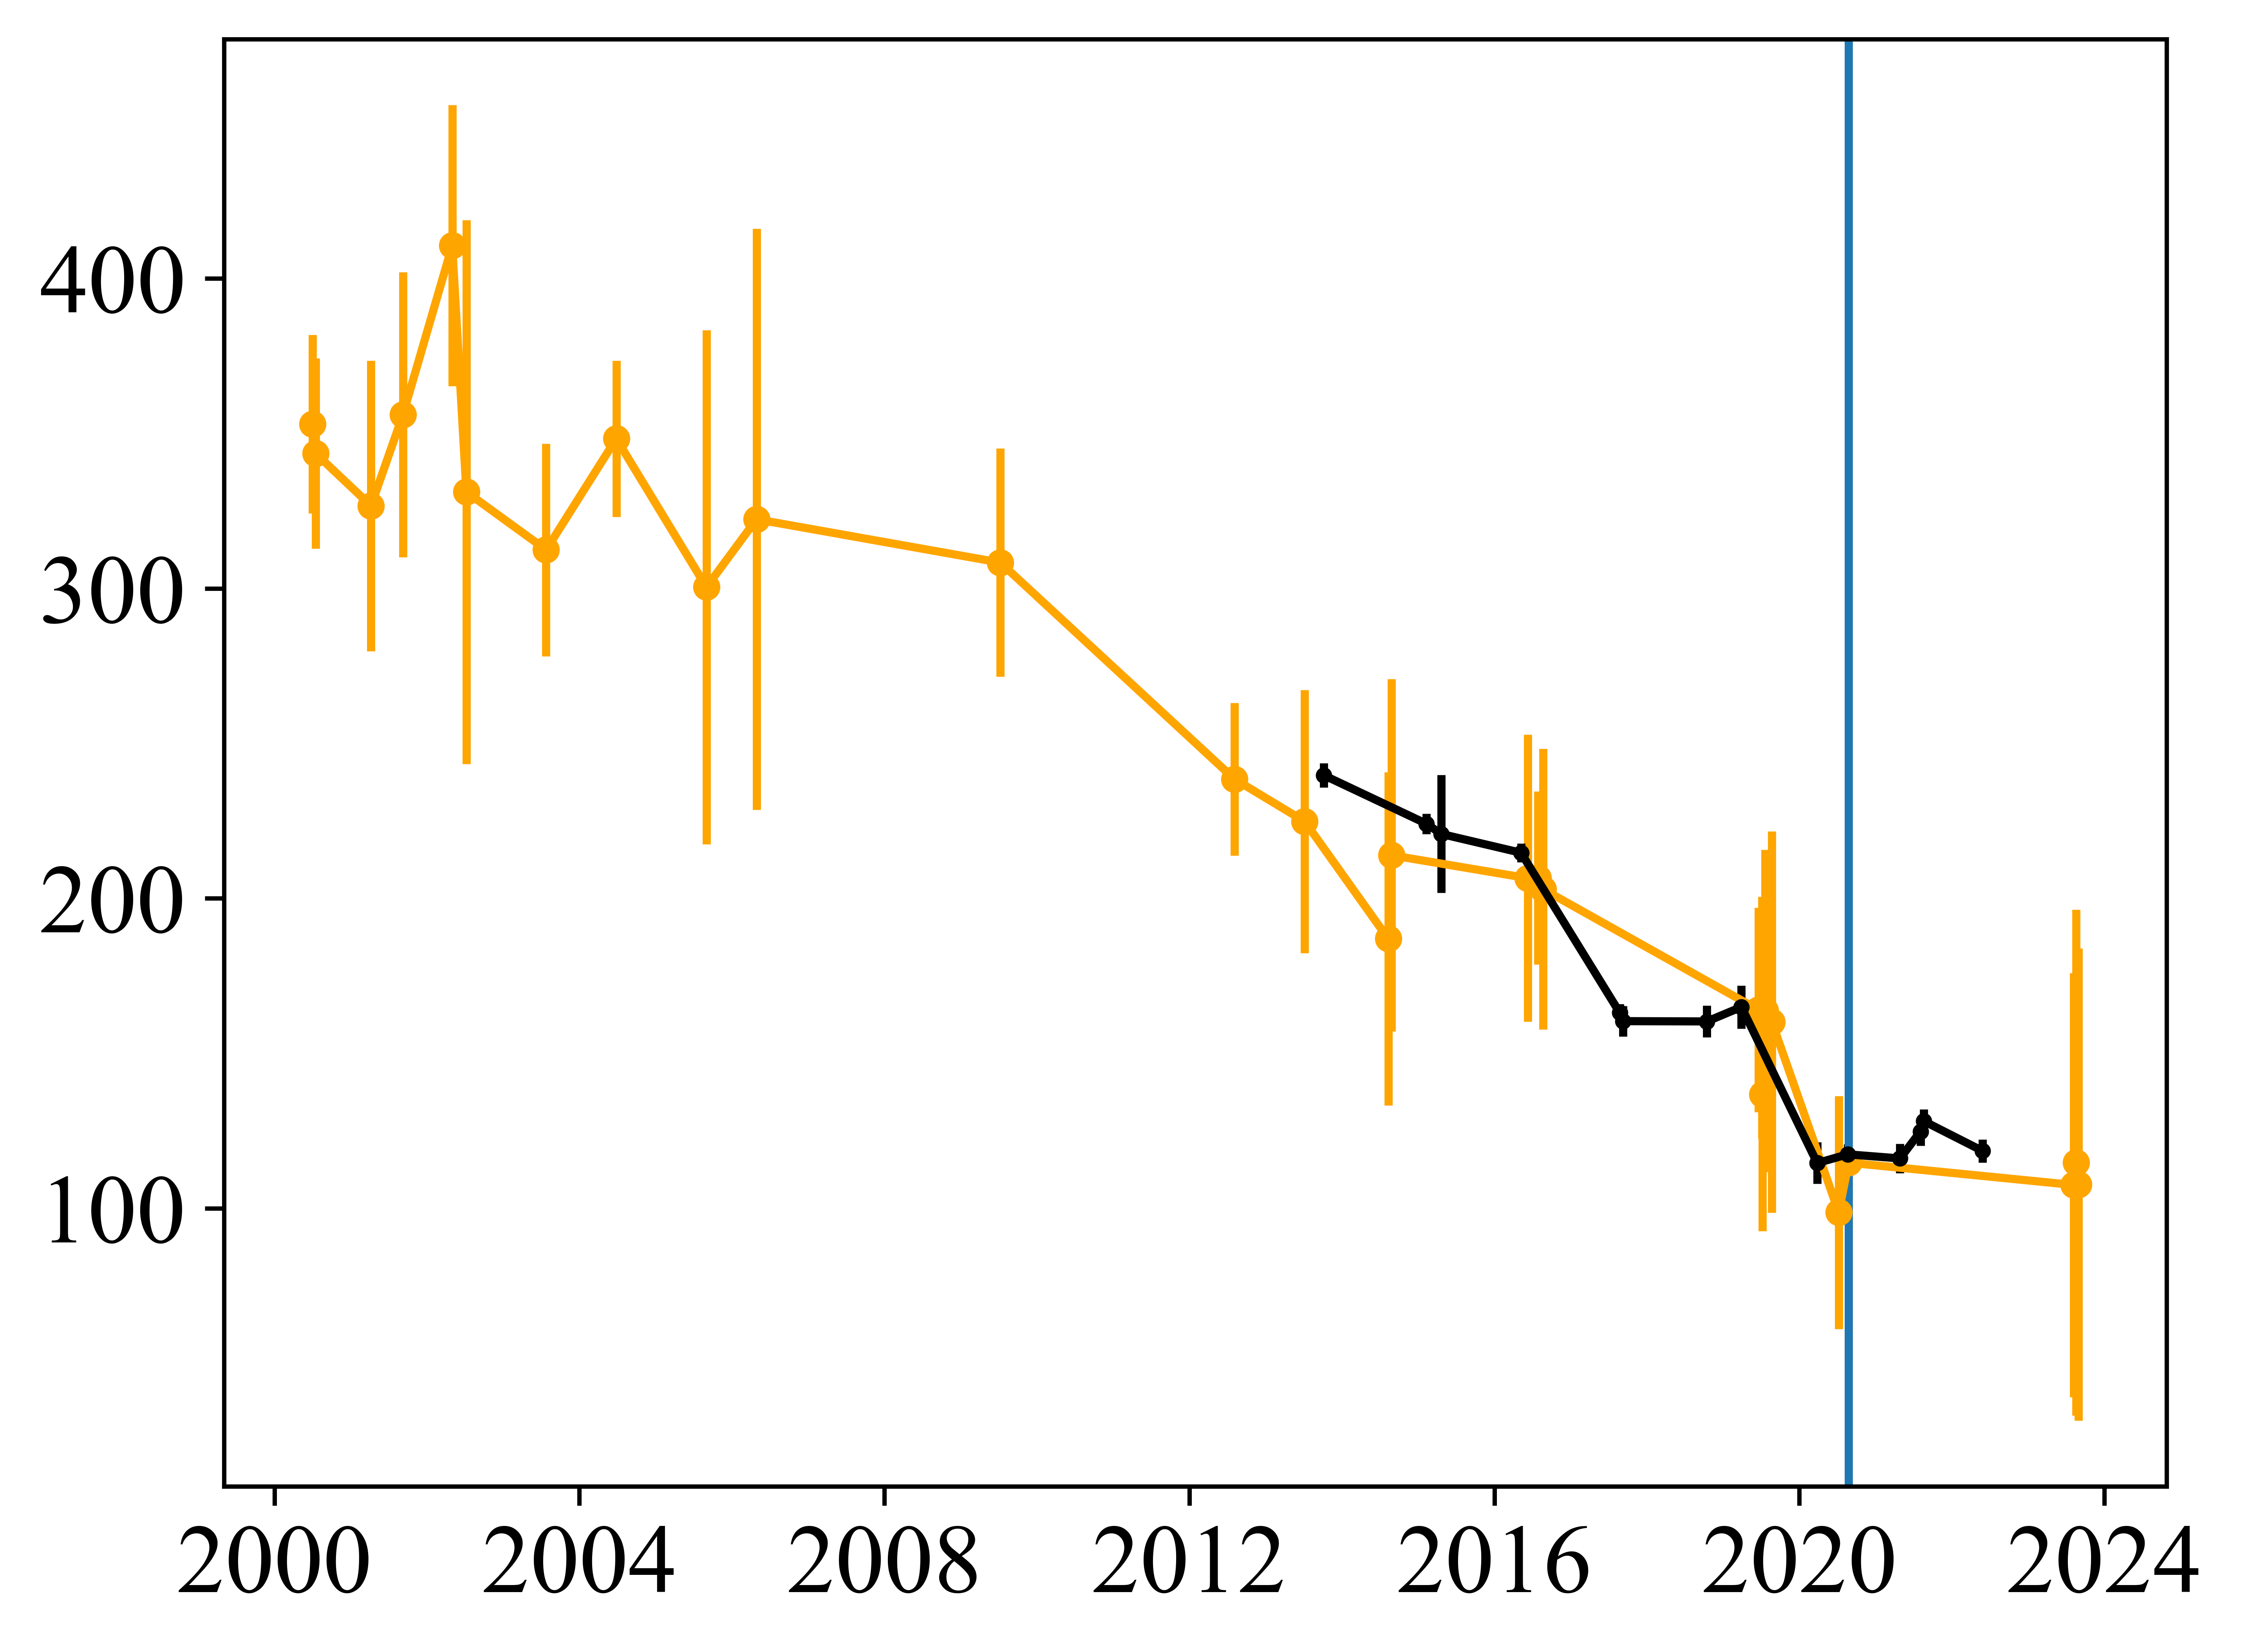

In [37]:
import matplotlib.pyplot as plt
import xarray as xr

POINT = 2000

fig, ax = plt.subplots()

asterdem_geoid = xr.open_dataset(
    "../data/elevation/asterdem/elevation_asterdem_points_2000_2024_geoid.nc"
).load()

asterdem_geoid = asterdem_geoid.where(dem_results.coreg_rmse < 100)
asterdem_geoid = asterdem_geoid.sel(cd=POINT)
asterdem_geoid_dj = asterdem_geoid.sel(glacier_code="DJ")
asterdem_geoid_ui = asterdem_geoid.sel(glacier_code="UI")
# ax.errorbar(
#     asterdem_geoid_dj.h.squeeze().dropna("date").date.values,
#     asterdem_geoid_dj.h.squeeze().dropna("date"),
#     asterdem_geoid_dj.dropna("date").coreg_rmse,
#     marker="o",
#     markersize=4,
#     linestyle="-",
#     c="blue",
# )
ax.errorbar(
    asterdem_geoid_ui.h.squeeze().dropna("date").date.values,
    asterdem_geoid_ui.h.squeeze().dropna("date"),
    asterdem_geoid_ui.dropna("date").coreg_rmse,
    marker="o",
    markersize=4,
    linestyle="-",
    c="orange",
)


arcticdem_geoid_ui = (
    xr.open_dataset(
        "../data/elevation/arcticdem/elevation_arcticdem_points_2011_2022_geoid.nc"
    )
    .load()
    .sel(glacier_code="UI", cd=POINT)
)
arcticdem_geoid_dj = (
    xr.open_dataset(
        "../data/elevation/arcticdem/elevation_arcticdem_points_2011_2022_geoid.nc"
    )
    .load()
    .sel(glacier_code="DJ", cd=POINT)
)
# ax.errorbar(
#     arcticdem_geoid_dj.h.squeeze().dropna("date").date.values,
#     arcticdem_geoid_dj.h.squeeze().dropna("date"),
#     arcticdem_geoid_dj.dropna("date").coreg_rmse,
#     marker="o",
#     markersize=2,
#     linestyle="-",
#     c="red",
# )
ax.errorbar(
    arcticdem_geoid_ui.h.squeeze().dropna("date").date.values,
    arcticdem_geoid_ui.h.squeeze().dropna("date"),
    arcticdem_geoid_ui.dropna("date").coreg_rmse,
    marker="o",
    markersize=2,
    linestyle="-",
    c="black",
)


plt.axvline(np.datetime64("2020-08-24"))
# plt.xlim(np.datetime64("2020-01-01"), np.datetime64("2021-01-01"))
plt.show()

In [64]:
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from matplotlib.dates import DateFormatter, YearLocator
from matplotlib.offsetbox import AnchoredText
from matplotlib.gridspec import GridSpec

GLACIERS = ["DJ", "UI"]
SETTINGS = {
    "DJ": {
        "colour": [(0.122, 0.467, 0.706, 1.0), (0.122, 0.467, 0.706, 0.25)],
        "label": "Daugaard-Jensen",
    },
    "UI": {
        "colour": [(1.0, 0.498, 0.055, 1.0), (1.0, 0.498, 0.055, 0.25)],
        "label": "Uunartit Islands",
    },
}

# Global plot settings
plt.rcParams["figure.dpi"] = 1000
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 18
plt.rcParams["axes.labelsize"] = 18
plt.rcParams["xtick.labelsize"] = 18
plt.rcParams["ytick.labelsize"] = 18

# Create figure and axes
fig = plt.figure(figsize=(16, 6))
gs = GridSpec(nrows=1, ncols=2, width_ratios=[1, 2], height_ratios=[1])
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1:])
ax = [ax0, ax1]

dj = xr.concat([asterdem_geoid_dj, arcticdem_geoid_dj], dim="date").sortby("date")
dj = dj.where(dj.coreg_rmse < 100, drop=True)
ui = xr.concat([asterdem_geoid_ui, arcticdem_geoid_ui], dim="date").sortby("date")
ui = ui.where(ui.coreg_rmse < 100, drop=True)

dj_dh = dj.h.squeeze().dropna("date") - dj.h.squeeze().dropna("date")[0]
ui_dh = ui.h.squeeze().dropna("date") - ui.h.squeeze().dropna("date")[0]

ax0_slice = [np.datetime64("1985", "ns"), np.datetime64("2010", "ns")]
ax1_slice = [np.datetime64("2010", "ns"), np.datetime64("2024", "ns")]

dj_dh_ax0 = dj_dh.where(
    (dj_dh.date >= ax0_slice[0]) & (dj_dh.date <= ax0_slice[1]),
    drop=True,
)
dj_dh_ax1 = dj_dh.where(
    (dj_dh.date >= ax1_slice[0]) & (dj_dh.date <= ax1_slice[1]),
    drop=True,
)

ui_dh_ax0 = ui_dh.where(
    (ui_dh.date >= ax0_slice[0]) & (ui_dh.date <= ax0_slice[1]),
    drop=True,
)
ui_dh_ax1 = ui_dh.where(
    (ui_dh.date >= ax1_slice[0]) & (ui_dh.date <= ax1_slice[1]),
    drop=True,
)

ax[0].plot(
    dj_dh_ax0.date.values,
    dj_dh_ax0,
    label=SETTINGS["DJ"]["label"],
    marker="o",
    linewidth=2.5,
    markersize=5,
    markeredgecolor=SETTINGS["DJ"]["colour"][0],
    markerfacecolor=SETTINGS["DJ"]["colour"][0],
    color=SETTINGS["DJ"]["colour"][1],
)
ax[0].plot(
    ui_dh_ax0.date.values,
    ui_dh_ax0,
    label=SETTINGS["UI"]["label"],
    marker="o",
    linewidth=2.5,
    markersize=5,
    markeredgecolor=SETTINGS["UI"]["colour"][0],
    markerfacecolor=SETTINGS["UI"]["colour"][0],
    color=SETTINGS["UI"]["colour"][1],
)
ax[1].plot(
    ui_dh_ax1.date.values,
    ui_dh_ax1,
    label=SETTINGS["UI"]["label"],
    marker="o",
    linewidth=2.5,
    markersize=5,
    markeredgecolor=SETTINGS["UI"]["colour"][0],
    markerfacecolor=SETTINGS["UI"]["colour"][0],
    color=SETTINGS["UI"]["colour"][1],
)
ax[1].plot(
    dj_dh_ax1.date.values,
    dj_dh_ax1,
    label=SETTINGS["DJ"]["label"],
    marker="o",
    linewidth=2.5,
    markersize=5,
    markeredgecolor=SETTINGS["DJ"]["colour"][0],
    markerfacecolor=SETTINGS["DJ"]["colour"][0],
    color=SETTINGS["DJ"]["colour"][1],
)

# Set y-axis range to fit data and adds label
ax[0].set_ylim(bottom=-300, top=20)
ax[1].set_ylim(bottom=-300, top=20)
ax[0].set_ylabel("Relative elevation [m]", labelpad=20)

# Set x-axis range to fit data
ax[0].set_xlim(pd.to_datetime("1985-01-01"), pd.to_datetime("2010-01-01"))
ax[1].set_xlim(pd.to_datetime("2010-01-01"), pd.to_datetime("2024-01-01"))

# Set x-axis tick frequency (major)
ax[0].xaxis.set_major_locator(YearLocator(base=5))
ax[0].xaxis.set_major_formatter(DateFormatter("%Y"))
ax[1].xaxis.set_major_formatter(DateFormatter("%Y"))

# Set x-axis tick frequency (minor)
ax[0].xaxis.set_minor_locator(YearLocator(1))
ax[1].xaxis.set_minor_locator(YearLocator(1))

# Rotate x-axis tick labels
ax[0].tick_params(axis="x", rotation=70)
ax[1].tick_params(axis="x", rotation=70)

# Disable y-axis tick labels
ax[1].tick_params(labelleft=False)

# Remove whitespace around data on plot
ax[0].margins(x=0)
ax[1].margins(x=0)

# Draw horizontal line at y=0
ax[0].axhline(y=0, c="black", alpha=0.7, linewidth=0.7, zorder=1, linestyle=(0, (6, 8)))
ax[1].axhline(y=0, c="black", alpha=0.7, linewidth=0.7, zorder=1, linestyle=(0, (6, 8)))

# Add plot labels and advance/retreat text
ax[0].add_artist(
    AnchoredText(
        "(a)",
        loc="upper left",
        borderpad=0.1,
        prop=dict(size=18, family="Times New Roman", weight="semibold", c="black"),
        frameon=False,
    )
)
ax[1].add_artist(
    AnchoredText(
        "(b)",
        loc="upper left",
        borderpad=0.1,
        prop=dict(size=18, family="Times New Roman", weight="semibold", c="black"),
        frameon=False,
    )
)
ax[0].text(
    0.98, 0.90, "Thickening ↑", alpha=0.8, size=18, ha="right", transform=ax[0].transAxes
)
ax[0].text(0.98, 0.82, "Thinning ↓", alpha=0.8, size=18, ha="right", transform=ax[0].transAxes)

# Draw legend
ax[0].legend(
    frameon=False,
    loc="lower left",
    fontsize=16,
    markerscale=2,
    scatterpoints=1,
)

# Add gridlines
ax[0].grid(
    True,
    which="major",
    axis="both",
    c="gray",
    linestyle=":",
    linewidth=0.5,
    alpha=0.8,
    zorder=0,
)
ax[1].grid(
    True,
    which="both",
    axis="both",
    c="gray",
    linestyle=":",
    linewidth=0.5,
    alpha=0.8,
    zorder=0,
)

plt.tight_layout()
plt.savefig(
    "../img/elevation_arcticdem_2011_2022_time-series.png",
    dpi=fig.dpi,
    bbox_inches="tight",
)
plt.show()

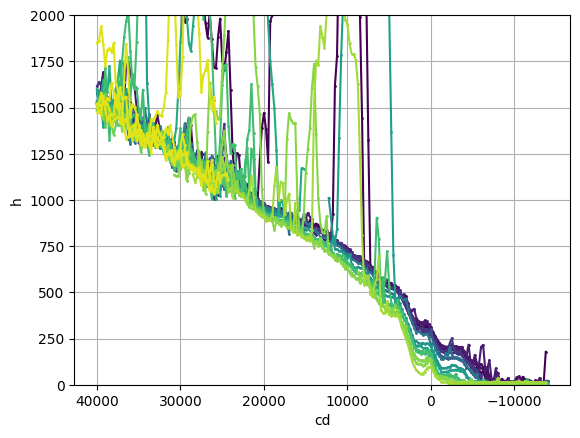

In [17]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.cm import viridis
from matplotlib.colors import Normalize

dem_results = xr.open_dataset(
    "../data/elevation/asterdem/elevation_asterdem_points_2000_2024_geoid.nc"
).load()
dem_results = dem_results.where(dem_results.coreg_rmse < 50)
# years = set(asterdem_results.date.dt.year.values)
date_values = mdates.date2num(dem_results.date.values)
norm = Normalize(vmin=np.min(date_values), vmax=np.max(date_values))
cmap = viridis

for date, date_value in zip(dem_results.date.values, date_values):
    h = dem_results.h.sel(glacier_code="UI", date=date).squeeze()

    color_value = norm(date_value)
    color = cmap(color_value)
    plt.plot(h.cd.values, h.values, color=color, marker="o", markersize=1)

plt.xlabel("cd")
plt.ylabel("h")
# plt.xlim(-1000, 5000)
plt.ylim(0, 2000)
plt.grid(True)
plt.gca().invert_xaxis()
plt.show()

# Centreline plot

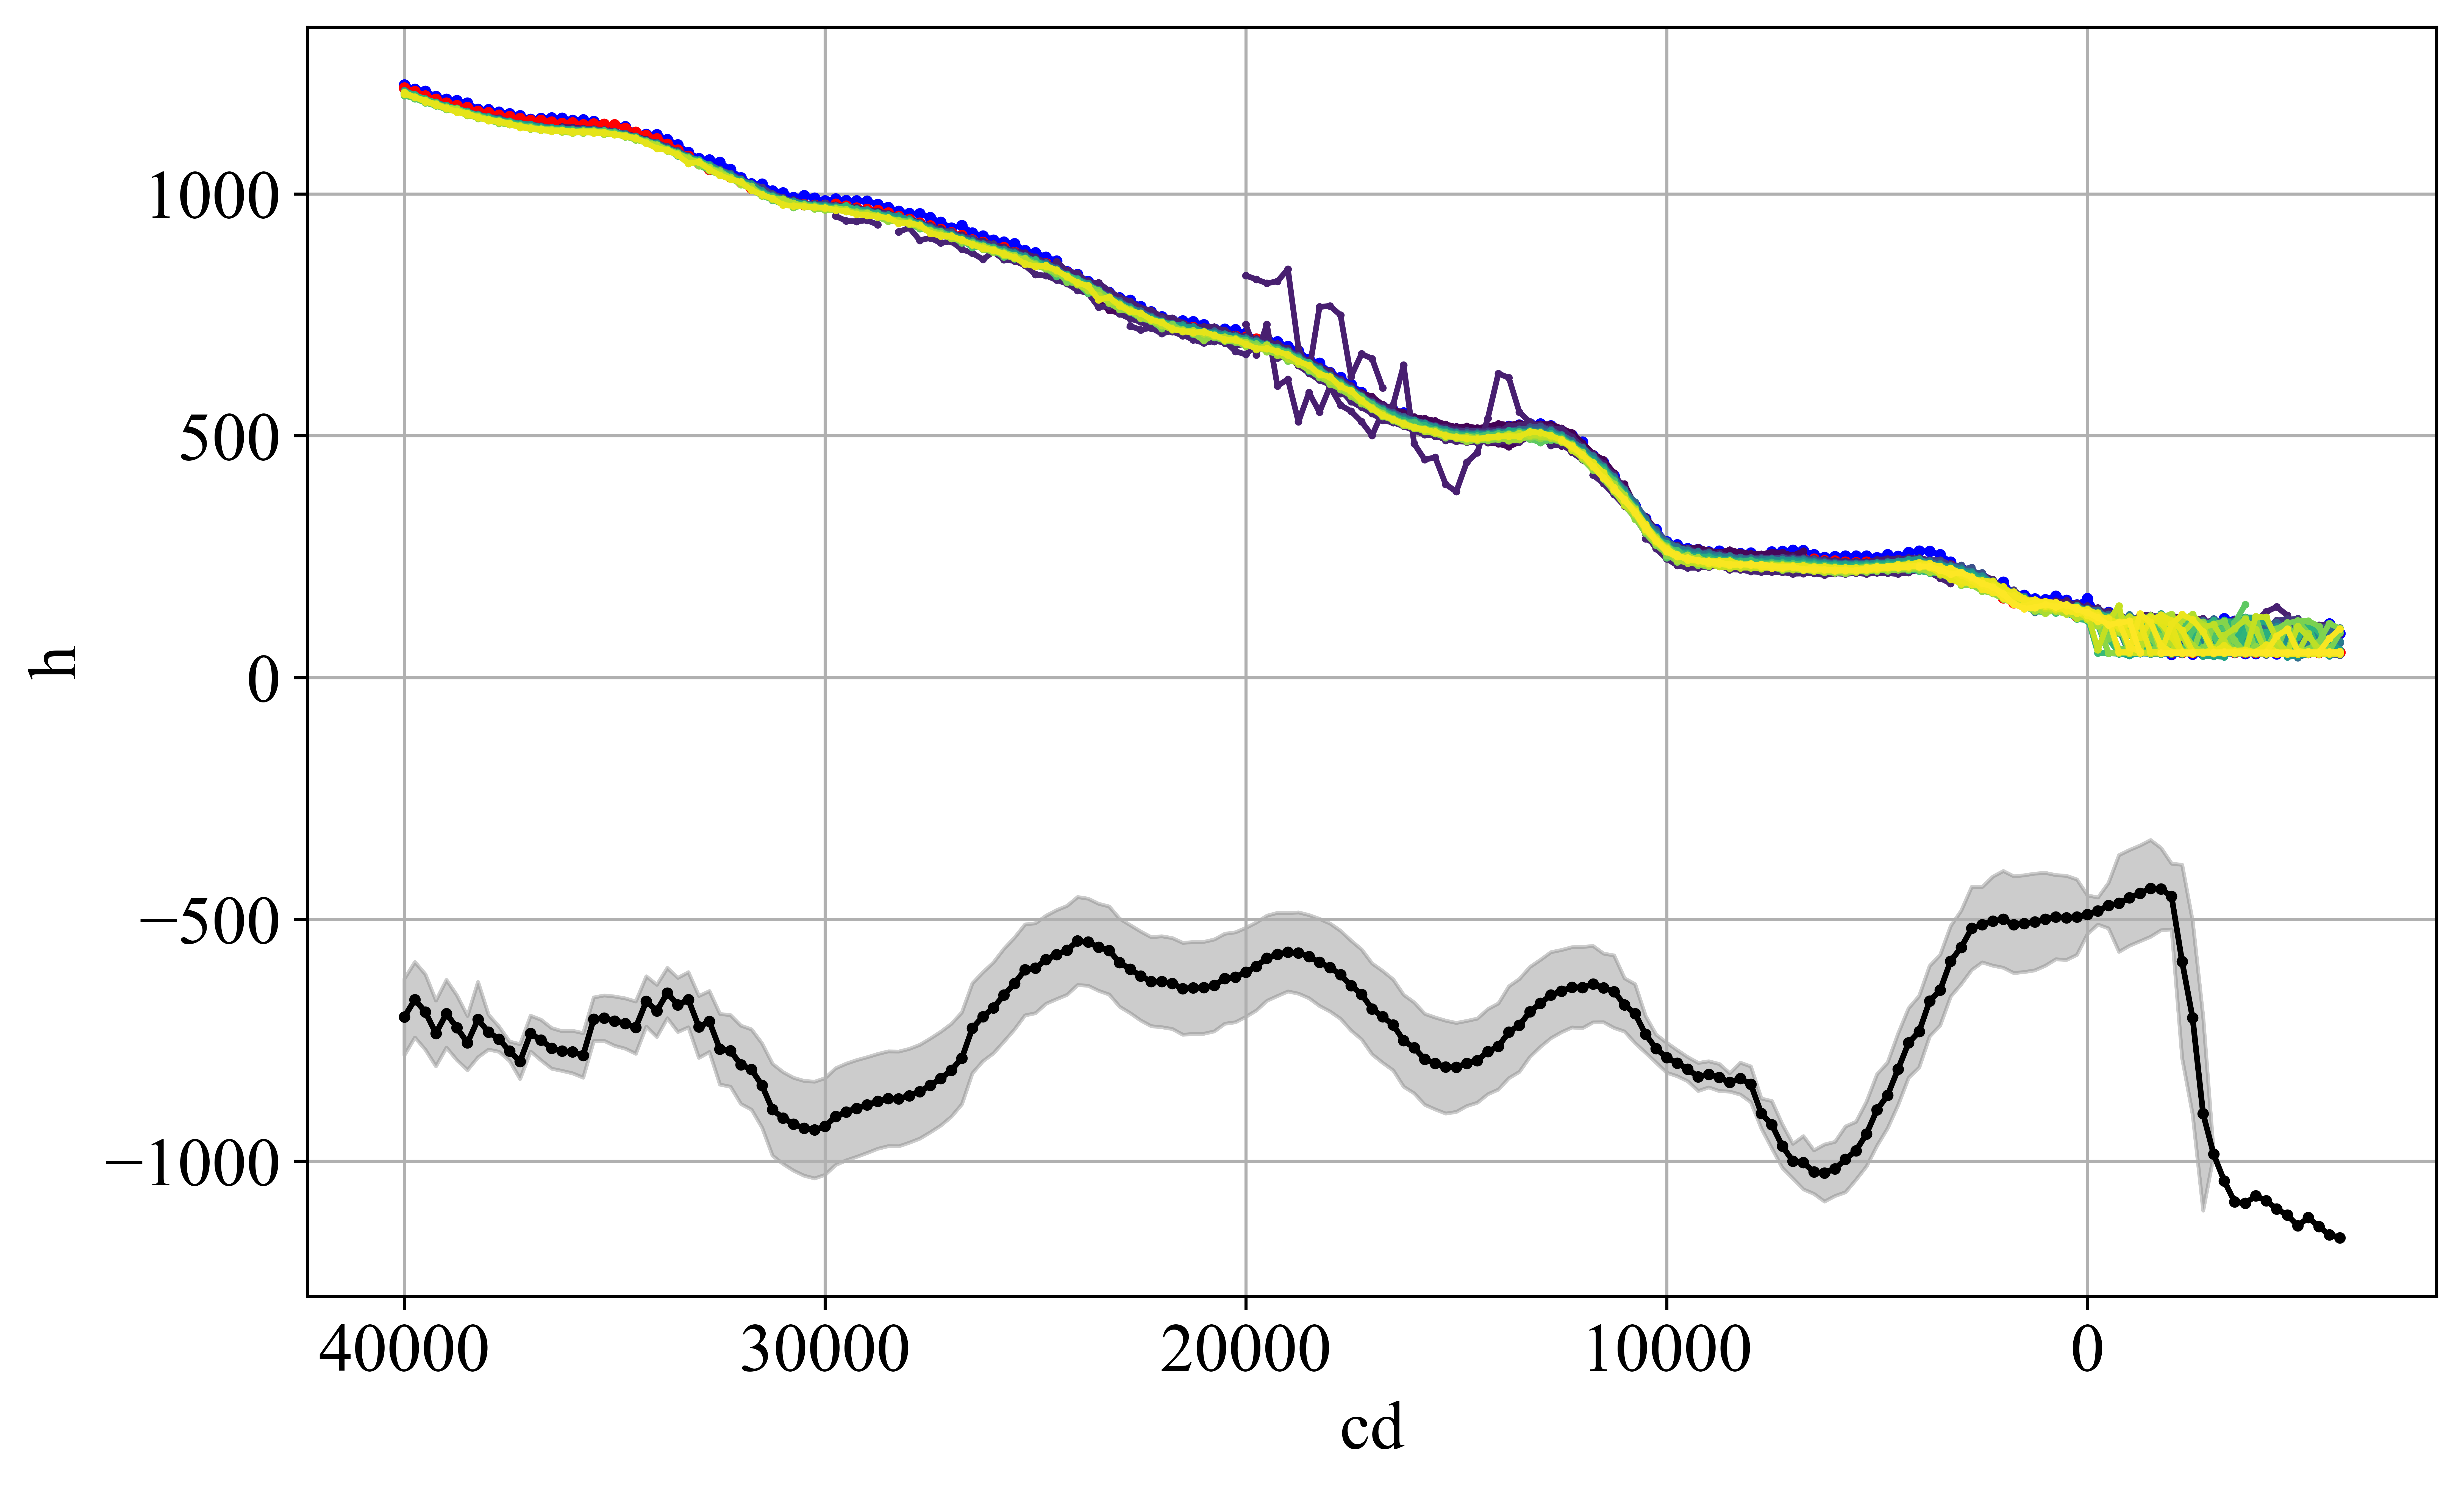

In [80]:
import xarray as xr
import rioxarray
import geopandas as gpd
import pandas as pd
import numpy as np

GLACIER = "DJ"


# Load the points from the .geojson file
geojson_path = "../data/misc/centreline_points.geojson"
points_gdf = gpd.read_file(geojson_path)
points_gdf = points_gdf.sort_values(by=["cd"]).reset_index()
points_gdf = points_gdf[points_gdf["glacier_code"] == GLACIER]
points_gdf = points_gdf[points_gdf["cd"] <= 40000]


aerodem = (
    "../data/elevation/aerodem/aerodem_1981_utm25.tif"
    if GLACIER == "UI"
    else "../data/elevation/aerodem/aerodem_1987_utm26_3.tif"
)
aerodem = rioxarray.open_rasterio(aerodem)
points_gdf = points_gdf.to_crs(aerodem.rio.crs)
coords = np.array([(geom.x, geom.y) for geom in points_gdf.geometry])
xs, ys = coords[:, 0], coords[:, 1]
areodem_sampled = aerodem.sel(
    x=xr.DataArray(xs, dims="points"), y=xr.DataArray(ys, dims="points"), method="nearest"
).values
points_gdf["aerodem"] = areodem_sampled.flatten()


bedmachine = "../data/misc/bedmachine/BedMachineGreenland-v5.nc"
bedmachine = xr.open_dataset(bedmachine)
coords = np.array([(geom.x, geom.y) for geom in points_gdf.geometry])
bedmachine_sampled = (
    bedmachine["bed"]
    .sel(
        x=xr.DataArray(xs, dims="points"), y=xr.DataArray(ys, dims="points"), method="nearest"
    )
    .values
)
points_gdf["bed"] = bedmachine_sampled

bedmachine_sampled_err = (
    bedmachine["errbed"]
    .sel(
        x=xr.DataArray(xs, dims="points"), y=xr.DataArray(ys, dims="points"), method="nearest"
    )
    .values
)
points_gdf["errbed"] = bedmachine_sampled_err

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(
    points_gdf["cd"],
    points_gdf["aerodem"],
    c="blue",
    marker="o",
    # linestyle="",
    markersize=2,
)
plt.plot(
    points_gdf["cd"],
    points_gdf["bed"],
    c="black",
    marker="o",
    # linestyle="",
    markersize=2,
)
plt.fill_between(
    points_gdf["cd"],
    points_gdf["bed"] - points_gdf["errbed"],
    points_gdf["bed"] + points_gdf["errbed"],
    color="grey",
    alpha=0.4,
)

# cs = ["#c1670f", "#db8706", "#f0a700", "#ffc800"]
# for i, year in enumerate(prodem_results.year):
#     h = prodem_results.band_data.sel(year=year, glacier_code=GLACIER)

#     plt.plot(h.cd.values, h.values, marker="o", c=cs[i], markersize=1)

arcticdem_results = xr.open_dataset(
    f"../data/elevation/arcticdem/{GLACIER.lower()}_arcticdem_points.nc"
).load()

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.cm import viridis
from matplotlib.colors import Normalize

years = set(arcticdem_results.date.dt.year.values)
date_values = mdates.date2num(arcticdem_results.date.values)
norm = Normalize(vmin=np.min(date_values), vmax=np.max(date_values))
cmap = viridis

for date, date_value in zip(arcticdem_results.date.values, date_values):
    h = arcticdem_results.h_median.sel(date=date).squeeze()

    color_value = norm(date_value)
    color = cmap(color_value)
    plt.plot(arcticdem_results.cd.values, h.values, color=color, marker="o", markersize=1)

plt.xlabel("cd")
plt.ylabel("h")
# plt.xlim(-1000, 5000)
# plt.ylim(0, 500)
plt.grid(True)
plt.gca().invert_xaxis()
plt.show()

# CryoTEMPO-EOLIS

EOLIS elevation data generated using swath processing of CryoSat data [(Gourmelen, N., Escorihuela, M., Shepherd, A., Foresta, L., Muir, A., Garcia-Mondejar, A., Roca, M., Baker, S., & Drinkwater, M. R. (2018))](https://doi.org/10.1016/j.asr.2017.11.014) and provided by the [ESA CryoTEMPO project](https://cryotempo-eolis.org/)

data downloaded from [cs2eo](https://cs2eo.org/) using [this search query](https://cs2eo.org/search?searchMode=single-polygon&productA=TEMPO_SWATH_GRID&polygon=[[-50.35,64.23],[-49.1,64.25],[-49.03,63.71],[-50.26,63.67],[-50.35,64.23]]&startDate=2010-01-01&startTime=00:00&endDate=2023-01-01&endTime=00:00&trackSpacing=100&batchRequest=false)
the `.csv` file generated from this is saved in `../data/sec/cryosat/`. This contains links to individual .nc files which can be downloaded with the below code.

In [ ]:
import json
from pathlib import Path

import ee
import geopandas as gpd
import numpy as np
import pandas as pd
import s3fs as s3
import xarray as xr
from shapely import LineString, Point
from shapely.ops import split
from scipy import stats

# only needs running if you need to download the files
path = "../data/sec/cryosat/"  # where to save the files / where the .csv file is
# path = glob(path+'*.csv')
# files = pd.read_csv(path[0])

# from ftplib import FTP
# password = 'ed.holt@ed.ac.uk'
# ftp = FTP('science-pds.cryosat.esa.int')
# ftp.login('anonymous',password)

# for product_path in tqdm(files['TEMPO_SWATH_GRID product path']):
#     path, file = os.path.split(product_path)
#     ftp.cwd(path)
#     with open(path+file, 'wb') as f:
#         ftp.retrbinary('RETR ' + file, f.write)

In [ ]:
ps = gpd.read_feather("../data/samplePoints_feather")
path = "../data/sec/cryosat/"  # where files are saved
cs_files = glob(path + "*.nc")

# read in stack of .nc files, add projection and convert time datetime
cs = xr.open_mfdataset(cs_files)  # cs means cryosat
cs = cs["elevation"].transpose("time", "y", "x").rio.write_crs("epsg:3413")

cs["time"] = pd.to_datetime(cs["time"], unit="s")

# get query points
xquery = ps.set_index(["glacier", "cd"])["x"].to_xarray()
yquery = ps.set_index(["glacier", "cd"])["y"].to_xarray()

# sample stack of .nc files, compute dask-chunks, and convert to dataframe
cs_sample = cs.sel(x=xquery, y=yquery, method="nearest")
cs_sample = xr.where(~(xquery.isnull()), cs_sample, np.nan).rename(
    "elevation"
)  # .to_dataframe()

cs_df = cs_sample.compute().to_dataframe().reset_index().dropna()

# add a years since earliest date for use in linear regression
cs_df["years"] = (cs_df["time"] - cs_df["time"].min()) / pd.Timedelta("365.25D")

# removing points along centreline where there are too few measurements
# measurements are not spaced far enough apart in time.
# needed because different time steps have different coverage
cs_date_range = cs_df.groupby(["glacier", "cd"])["years"].agg(np.ptp)
mean, std = cs_date_range.agg(["mean", "std"])
cs_df = cs_df.set_index(["glacier", "cd"]).loc[cs_date_range > (mean - std)].reset_index()

# linear regression for each point along each glacier centreline
cs_slopes = (
    cs_df.groupby(["glacier", "cd"])
    .apply(lambda q: pd.Series(stats.linregress(x=q["years"], y=q["elevation"])))
    .reset_index()
    .rename(columns={0: "slope", 1: "intercept", 2: "rvalue", 3: "pvalue", 4: "stderr"})
)

cs_slopes["Source"] = "CryoTEMPO-EOLIS"
cs_slopes[
    "Source:Period"
] = f'CryoTEMPO-EOLIS: {cs_df["time"].min().strftime("%b %Y")}-{cs_df["time"].max().strftime("%b %Y")}'

# ICESat-2 ATL15

In [4]:
from scipy import stats

ps = gpd.read_file("../data/misc/centreline_points.geojson")
ps = ps.sort_values(by=["glacier_code", "cd"]).reset_index()

atl15_file = "../data/elevation/icesat2/ATL15_GL_0318_01km_003_01.nc"
atl15 = xr.open_dataset(
    atl15_file, group="delta_h", chunks={"x": "auto", "y": "auto"}
).rio.write_crs(3413)

xquery = ps.set_index(["glacier_code", "cd"]).geometry.x.to_xarray()
yquery = ps.set_index(["glacier_code", "cd"]).geometry.y.to_xarray()

atl_sampled = atl15.sel(x=xquery, y=yquery, method="nearest")
atl_sampled = xr.where(~(xquery.isnull()), atl_sampled, np.nan)

# Compute years and days
time_min = atl_sampled.time.min().values
time_delta = (atl_sampled.time - time_min) / np.timedelta64(1, "D")  # Convert to days
years = time_delta / 365.25  # Convert days to years as float

# Combine years and days into a single coordinate
atl_sampled["years"] = xr.DataArray(years, dims="time")

atl_sampled = atl_sampled.compute()

# # slope, intercept, rvalue, pvalue, stderr
# atl_slopes = xr.apply_ufunc(
#     lambda x, y: np.array(stats.linregress(x, y)),
#     atl_sampled["years"],
#     atl_sampled["delta_h"],
#     input_core_dims=[["time"], ["time"]],
#     output_core_dims=[["stats"]],
#     vectorize=True,
# )

atl_sampled["Source"] = "IceSat-2 ATL15"
atl_sampled[
    "Source:Period"
] = f"ICESat-2 ATL15: {atl_sampled.time.min().values.astype('datetime64[D]')}-{atl_sampled.time.max().values.astype('datetime64[D]')}"

[  2.9646606    3.746643     5.581604     0.01245117  -0.8199463
   0.          -0.19000244  -3.2131958   -5.2870483   -4.6835327
  -3.918457    -6.9092407   -9.627563    -8.751831    -7.38208
  -9.910645   -11.523132    -9.41803     -9.526123  ]


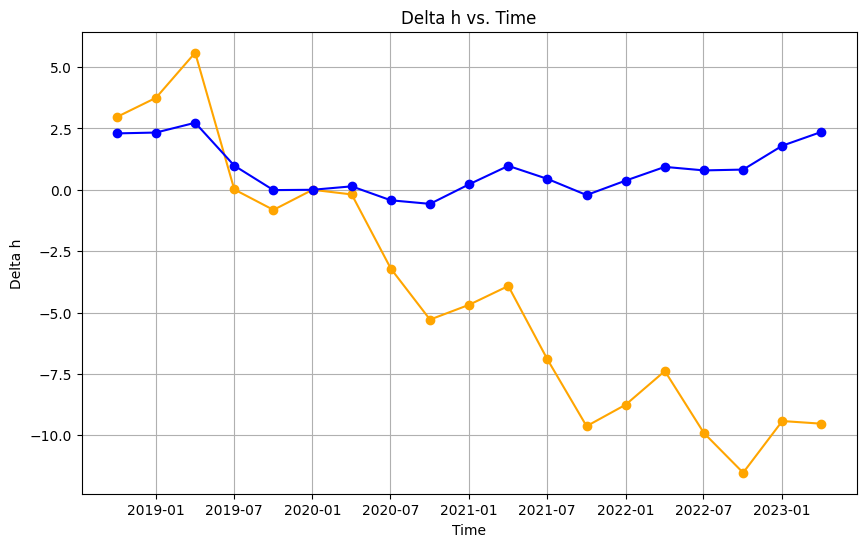

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

filtered = atl_sampled.sel(cd=10000)
filtered["time"] = pd.to_datetime(filtered["time"])

plt.figure(figsize=(10, 6))

filtered_df_ui = filtered.sel(glacier_code="UI")
print(filtered_df_ui["delta_h"].values)
plt.plot(filtered_df_ui["time"], filtered_df_ui["delta_h"], marker="o", c="orange")

filtered_df_dj = filtered.sel(glacier_code="DJ")
plt.plot(filtered_df_dj["time"], filtered_df_dj["delta_h"], marker="o", c="blue")


plt.title("Delta h vs. Time")
plt.xlabel("Time")
plt.ylabel("Delta h")
plt.grid(True)
plt.show()

2018-10-01T22:30:00.000000000
2019-01-01T06:00:00.000000000
2019-04-02T13:30:00.000000000
2019-07-02T21:00:00.000000000
2019-10-02T04:30:00.000000000
2020-01-01T12:00:00.000000000
2020-04-01T19:30:00.000000000
2020-07-02T03:00:00.000000000
2020-10-01T10:30:00.000000000
2020-12-31T18:00:00.000000000
2021-04-02T01:30:00.000000000
2021-07-02T09:00:00.000000000
2021-10-01T16:30:00.000000000
2022-01-01T00:00:00.000000000
2022-04-02T07:30:00.000000000
2022-07-02T15:00:00.000000000
2022-10-01T22:30:00.000000000
2023-01-01T06:00:00.000000000
2023-04-02T13:30:00.000000000


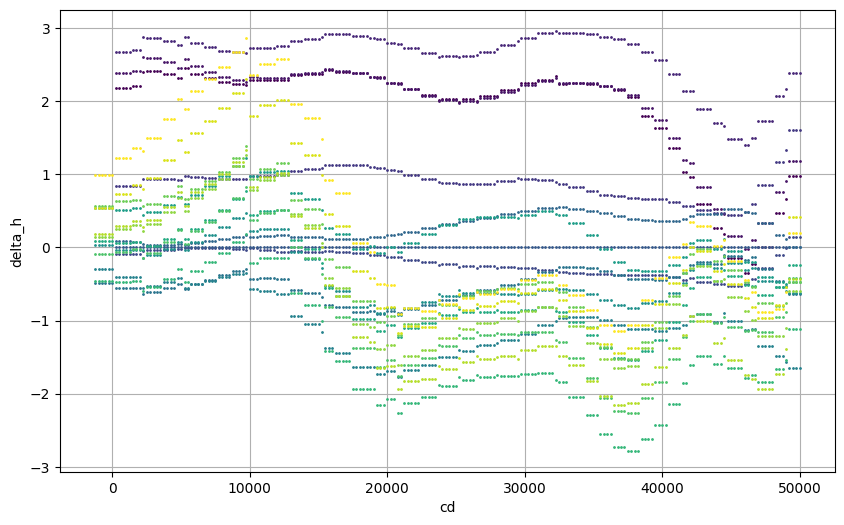

In [14]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import matplotlib.colorbar as colorbar

# Select the most recent time step
recent_time_step = atl_sampled["time"]
filtered["time"] = pd.to_datetime(filtered["time"])

plt.figure(figsize=(10, 6))

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.cm import viridis
from matplotlib.colors import Normalize

date_values = mdates.date2num(atl_sampled.time.values)
norm = Normalize(vmin=np.min(date_values), vmax=np.max(date_values))
cmap = viridis


for i, (time_step, date_value) in enumerate(zip(recent_time_step, date_values)):
    color_value = norm(date_value)
    color = cmap(color_value)
    print(time_step.values)
    recent = atl_sampled.sel(time=time_step)

    # filtered_df_ui = recent.sel(glacier_code="UI")
    # plt.plot(
    #     filtered_df_ui["cd"],
    #     filtered_df_ui["delta_h"],
    #     marker="o",
    #     label=time_step,
    #     color=color,
    #     markersize=1,
    #     linestyle="",
    # )

    filtered_df_dj = recent.sel(glacier_code="DJ")
    plt.plot(
        filtered_df_dj["cd"],
        filtered_df_dj["delta_h"],
        marker="o",
        markersize=1,
        linestyle="",
        label=time_step,
        color=color,
    )

# Plot delta_h against cd
plt.xlabel("cd")
plt.ylabel("delta_h")
# plt.legend()
plt.grid(True)
plt.show()

2018-10-01T22:30:00.000000000
2019-01-01T06:00:00.000000000
2019-04-02T13:30:00.000000000
2019-07-02T21:00:00.000000000
2019-10-02T04:30:00.000000000
2020-01-01T12:00:00.000000000
2020-04-01T19:30:00.000000000
2020-07-02T03:00:00.000000000
2020-10-01T10:30:00.000000000
2020-12-31T18:00:00.000000000
2021-04-02T01:30:00.000000000
2021-07-02T09:00:00.000000000
2021-10-01T16:30:00.000000000
2022-01-01T00:00:00.000000000
2022-04-02T07:30:00.000000000
2022-07-02T15:00:00.000000000
2022-10-01T22:30:00.000000000
2023-01-01T06:00:00.000000000
2023-04-02T13:30:00.000000000


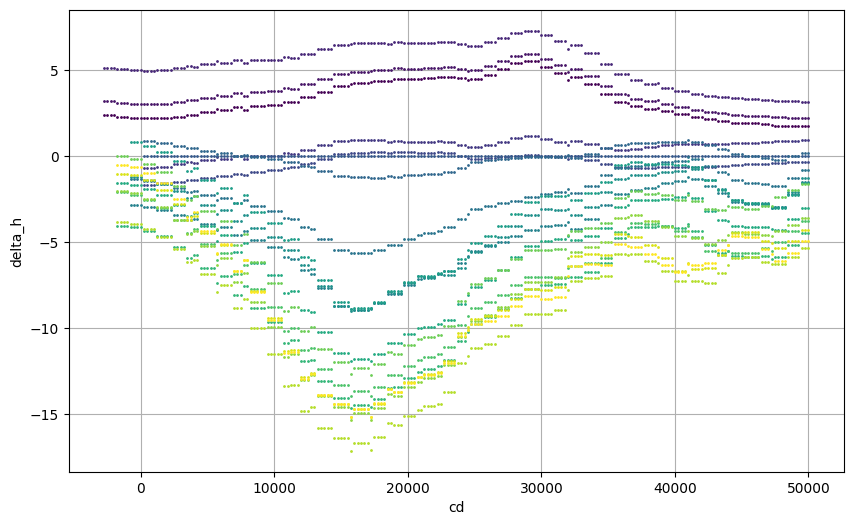

In [19]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import matplotlib.colorbar as colorbar

# Select the most recent time step
recent_time_step = atl_sampled["time"]
filtered["time"] = pd.to_datetime(filtered["time"])

plt.figure(figsize=(10, 6))

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.cm import viridis
from matplotlib.colors import Normalize

date_values = mdates.date2num(atl_sampled.time.values)
norm = Normalize(vmin=np.min(date_values), vmax=np.max(date_values))
cmap = viridis


for i, (time_step, date_value) in enumerate(zip(recent_time_step, date_values)):
    color_value = norm(date_value)
    color = cmap(color_value)
    print(time_step.values)
    recent = atl_sampled.sel(time=time_step)
    filtered_df_ui = recent.sel(glacier_code="UI")

    plt.plot(
        filtered_df_ui.delta_h.cd,
        filtered_df_ui.delta_h,
        marker="o",
        label=time_step,
        color=color,
        markersize=1,
        linestyle="",
    )

# Plot delta_h against cd
plt.xlabel("cd")
plt.ylabel("delta_h")
# plt.legend()
plt.grid(True)
plt.show()